In [1]:
%run notebook_config

# Nested sampling

In this example, we fit the same event with the same model as in the annual parallax example, except using dynamic nested sampling as implemented in [dynesty](https://dynesty.readthedocs.io/en/latest/index.html) instead of Hamiltonian Monte Carlo.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


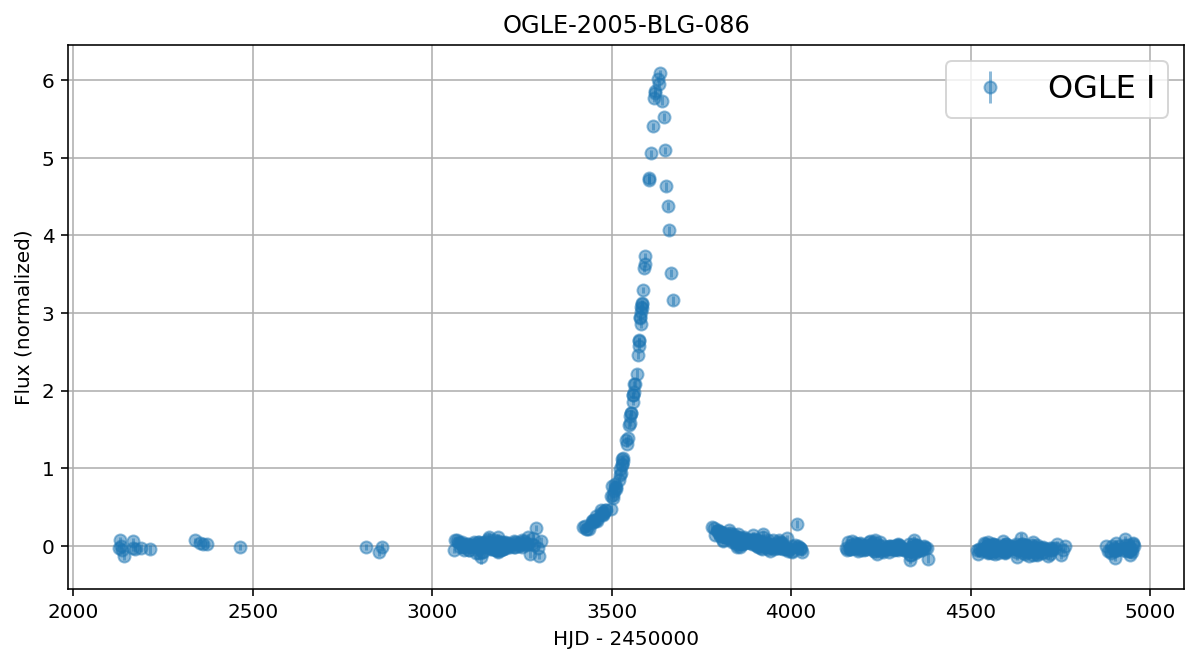

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm
import theano.tensor as T

import caustic as ca
import dynesty
from dynesty import utils as dyfunc

np.random.seed(42)

# Load event data
event_dir = "../../data/OB05086/"
event = ca.data.OGLEData(event_dir)

# Plot data
fig, ax = plt.subplots(figsize=(10, 5))
event.plot_standardized_data(ax);

In [108]:
# Initialize a SingleLensModel object
model = ca.models.SingleLensModel(event)

with model:
    n_bands = len(event.light_curves)

    # Initialize linear parameters
    testval_ln_DeltaF = T.log(
        ca.utils.estimate_peak_flux(event) - ca.utils.estimate_baseline_flux(event)
    )  # helper functions
    ln_DeltaF = pm.Normal("ln_DeltaF", mu=4.0, sd=4, testval=testval_ln_DeltaF[0])
    DeltaF = T.exp(ln_DeltaF)

    ln_Fbase = pm.Normal(
        "ln_Fbase", mu=2, sd=4, testval=T.log(ca.utils.estimate_baseline_flux(event)[0])
    )
    Fbase = T.exp(ln_Fbase)

    # Initialize nonlinear parameters
    t0 = pm.Uniform(
        "t0",
        model.t_min,
        2 * model.t_max,
        testval=ca.utils.estimate_t0(event),
        transform=None,
    )
    ln_tE = pm.Normal("ln_tE", mu=3.0, sd=6, testval=2.0)
    tE = pm.Deterministic("tE", T.exp(ln_tE))

    # In the parallax model, u_0 can be negative
    u0 = pm.Normal("u0", mu=0.0, sd=3, testval=-0.41)

    # Initialize the two parallax parameters
    piEE = pm.Normal("piEE", mu=0.0, sigma=1.0, testval=0.1)
    piEN = pm.Normal("piEN", mu=0.0, sigma=1.0, testval=-0.3)

    # Deterministic transformations
    m_source, g = ca.compute_source_mag_and_blend_fraction(event, DeltaF, Fbase, u0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    pm.Deterministic("piE", T.sqrt(piEE ** 2 + piEN ** 2))

    # Compute the trajectory including parallax
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE, piEE=piEE, piEN=piEN)
    u = trajectory.compute_trajectory(model.t)

    # Compute the magnification
    mag = model.compute_magnification(u, u0)

    # Compute the mean model
    mean = DeltaF * mag + Fbase

    # We allow for rescaling of the error bars by a constant factor
    ln_c = pm.Exponential("ln_c", 0.5, testval=0.8 * T.ones(n_bands), transform=None)

    # Diagonal terms of the covariance matrix
    var_F = (T.exp(ln_c) * model.sigF) ** 2

    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = model.compute_log_likelihood(model.F - mean, var_F)
    pm.Potential("log_likelihood", ll)

    # We'll need this later
    pm.Deterministic("log_likelihood_", ll)

In [109]:
print(model.vars)

[ln_DeltaF, ln_Fbase, t0, ln_tE, u0, piEE, piEN, ln_c]


To use dynamic nested sampling, we have to re write the priors in the form of a prior transfer function which maps i.i.d uniformly distributed parameters defined on a unit cube to our parameters of interest. The `ppf` function associated with probability distributions defined in `scipy.stats` does exactly that. To learn why this step is necessary, check out the [dynesty docs](https://dynesty.readthedocs.io/en/latest/quickstart.html#prior-transforms). 

In [5]:
import scipy


def prior_transform(u):
    """
    Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest.
    """
    x = np.array(u)  # copy u

    # ln_DeltaF
    x[0] = scipy.stats.norm.ppf(u[0], loc=5.0, scale=2.0)

    # ln_Fbase
    x[1] = scipy.stats.norm.ppf(u[1], loc=4.0, scale=3.0)

    # t0
    x[2] = scipy.stats.norm.ppf(u[2], model.t_min, model.t_max)

    # ln_tE
    x[3] = scipy.stats.norm.ppf(u[3], loc=3.0, scale=3.0)

    # u0
    x[4] = scipy.stats.norm.ppf(u[4], loc=0.0, scale=1.0)

    # pi_EE
    x[5] = scipy.stats.norm.ppf(u[5], loc=0.0, scale=0.5)

    # pi_EN
    x[6] = scipy.stats.norm.ppf(u[6], loc=0.0, scale=0.5)

    # ln_c
    x[7] = scipy.stats.expon.ppf(u[7], scale=1 / 0.5)

    return x

In [6]:
model.vars

[ln_DeltaF, ln_Fbase, t0_interval__, ln_tE, u0, piEE, piEN, ln_c_log__]

Let's run the sampling, this will take some time...

In [7]:
# This will take a long time
with model:
    loglike = ca.utils.get_log_likelihood_function(model.log_likelihood)

ndim = len(model.vars)
sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim, sample="rwalk")

sampler.run_nested(wt_kwargs={"pfrac": 1.0}, print_progress=True, nlive_init=500)

results = sampler.results

# Resample samples such that they have equal weight
samples_reweighted, weights = results.samples, np.exp(results.logwt - results.logz[-1])
new_samples = dyfunc.resample_equal(samples, weights)

8326it [05:28, 20.94it/s, batch: 0 | bound: 98 | nc: 25 | ncall: 185965 | eff(%):  4.465 | loglstar:   -inf < -2803.630 <    inf | logz: -2825.214 +/-  0.289 | dlogz: 540.543 >  0.010]  /Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/dynesty/sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
8614it [05:41, 23.03it/s, batch: 0 | bound: 103 | nc: 25 | ncall: 193750 | eff(%):  4.434 | loglstar:   -inf < -2739.238 <    inf | logz: -2761.476 +/-  0.289 | dlogz: 479.079 >  0.010]/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/dynesty/sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
8678it [05:46, 24.18it/s, batch: 0 | bound: 105 | nc: 25 | ncall: 197085 | eff(%):  4.392 | loglstar:   -inf < 

The sampling appears to have converged according to internal criteria specified in dynesty with a total of ~2M likelihood calls, let's plot the diagnostics plots.

/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


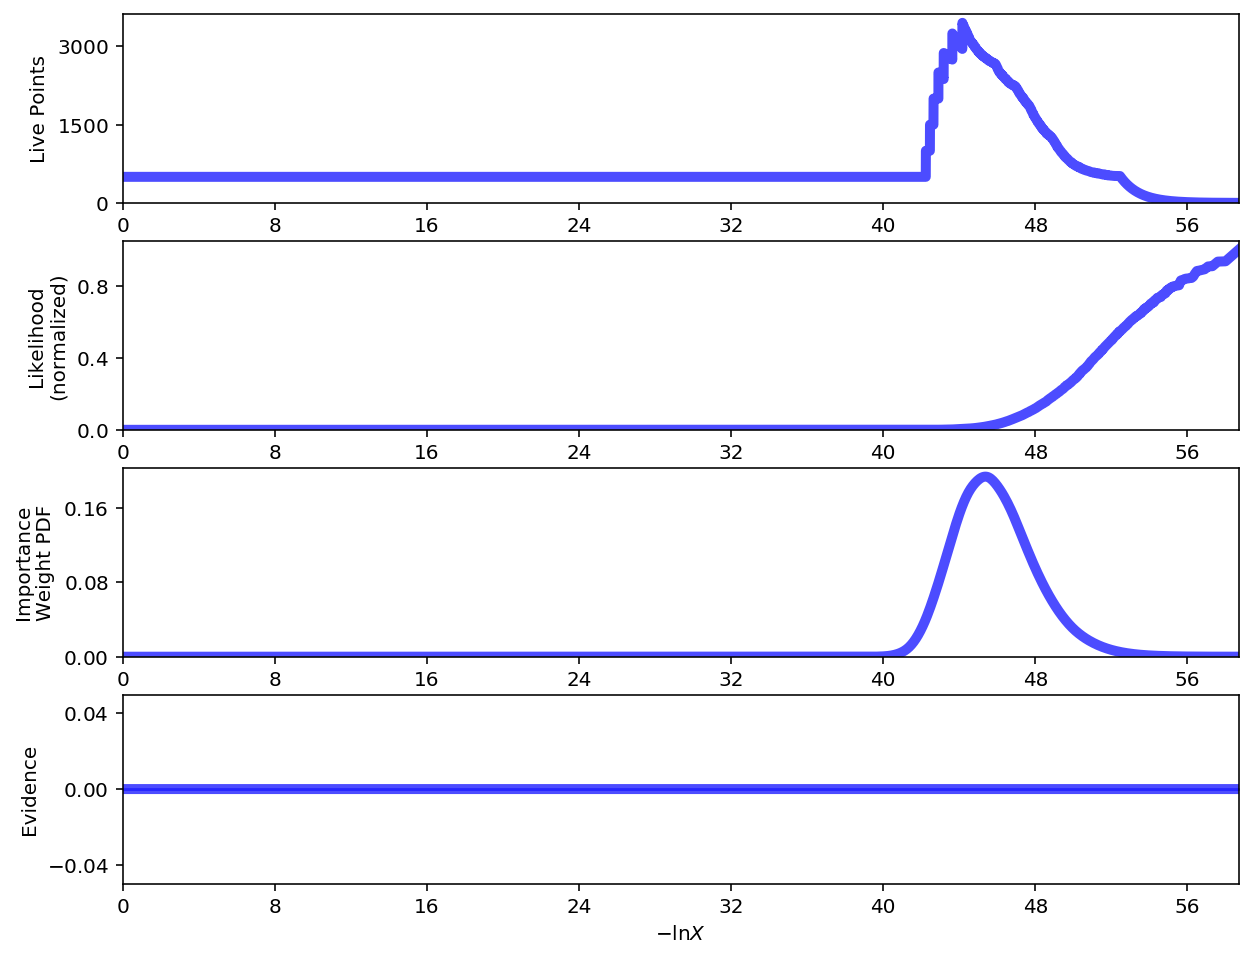

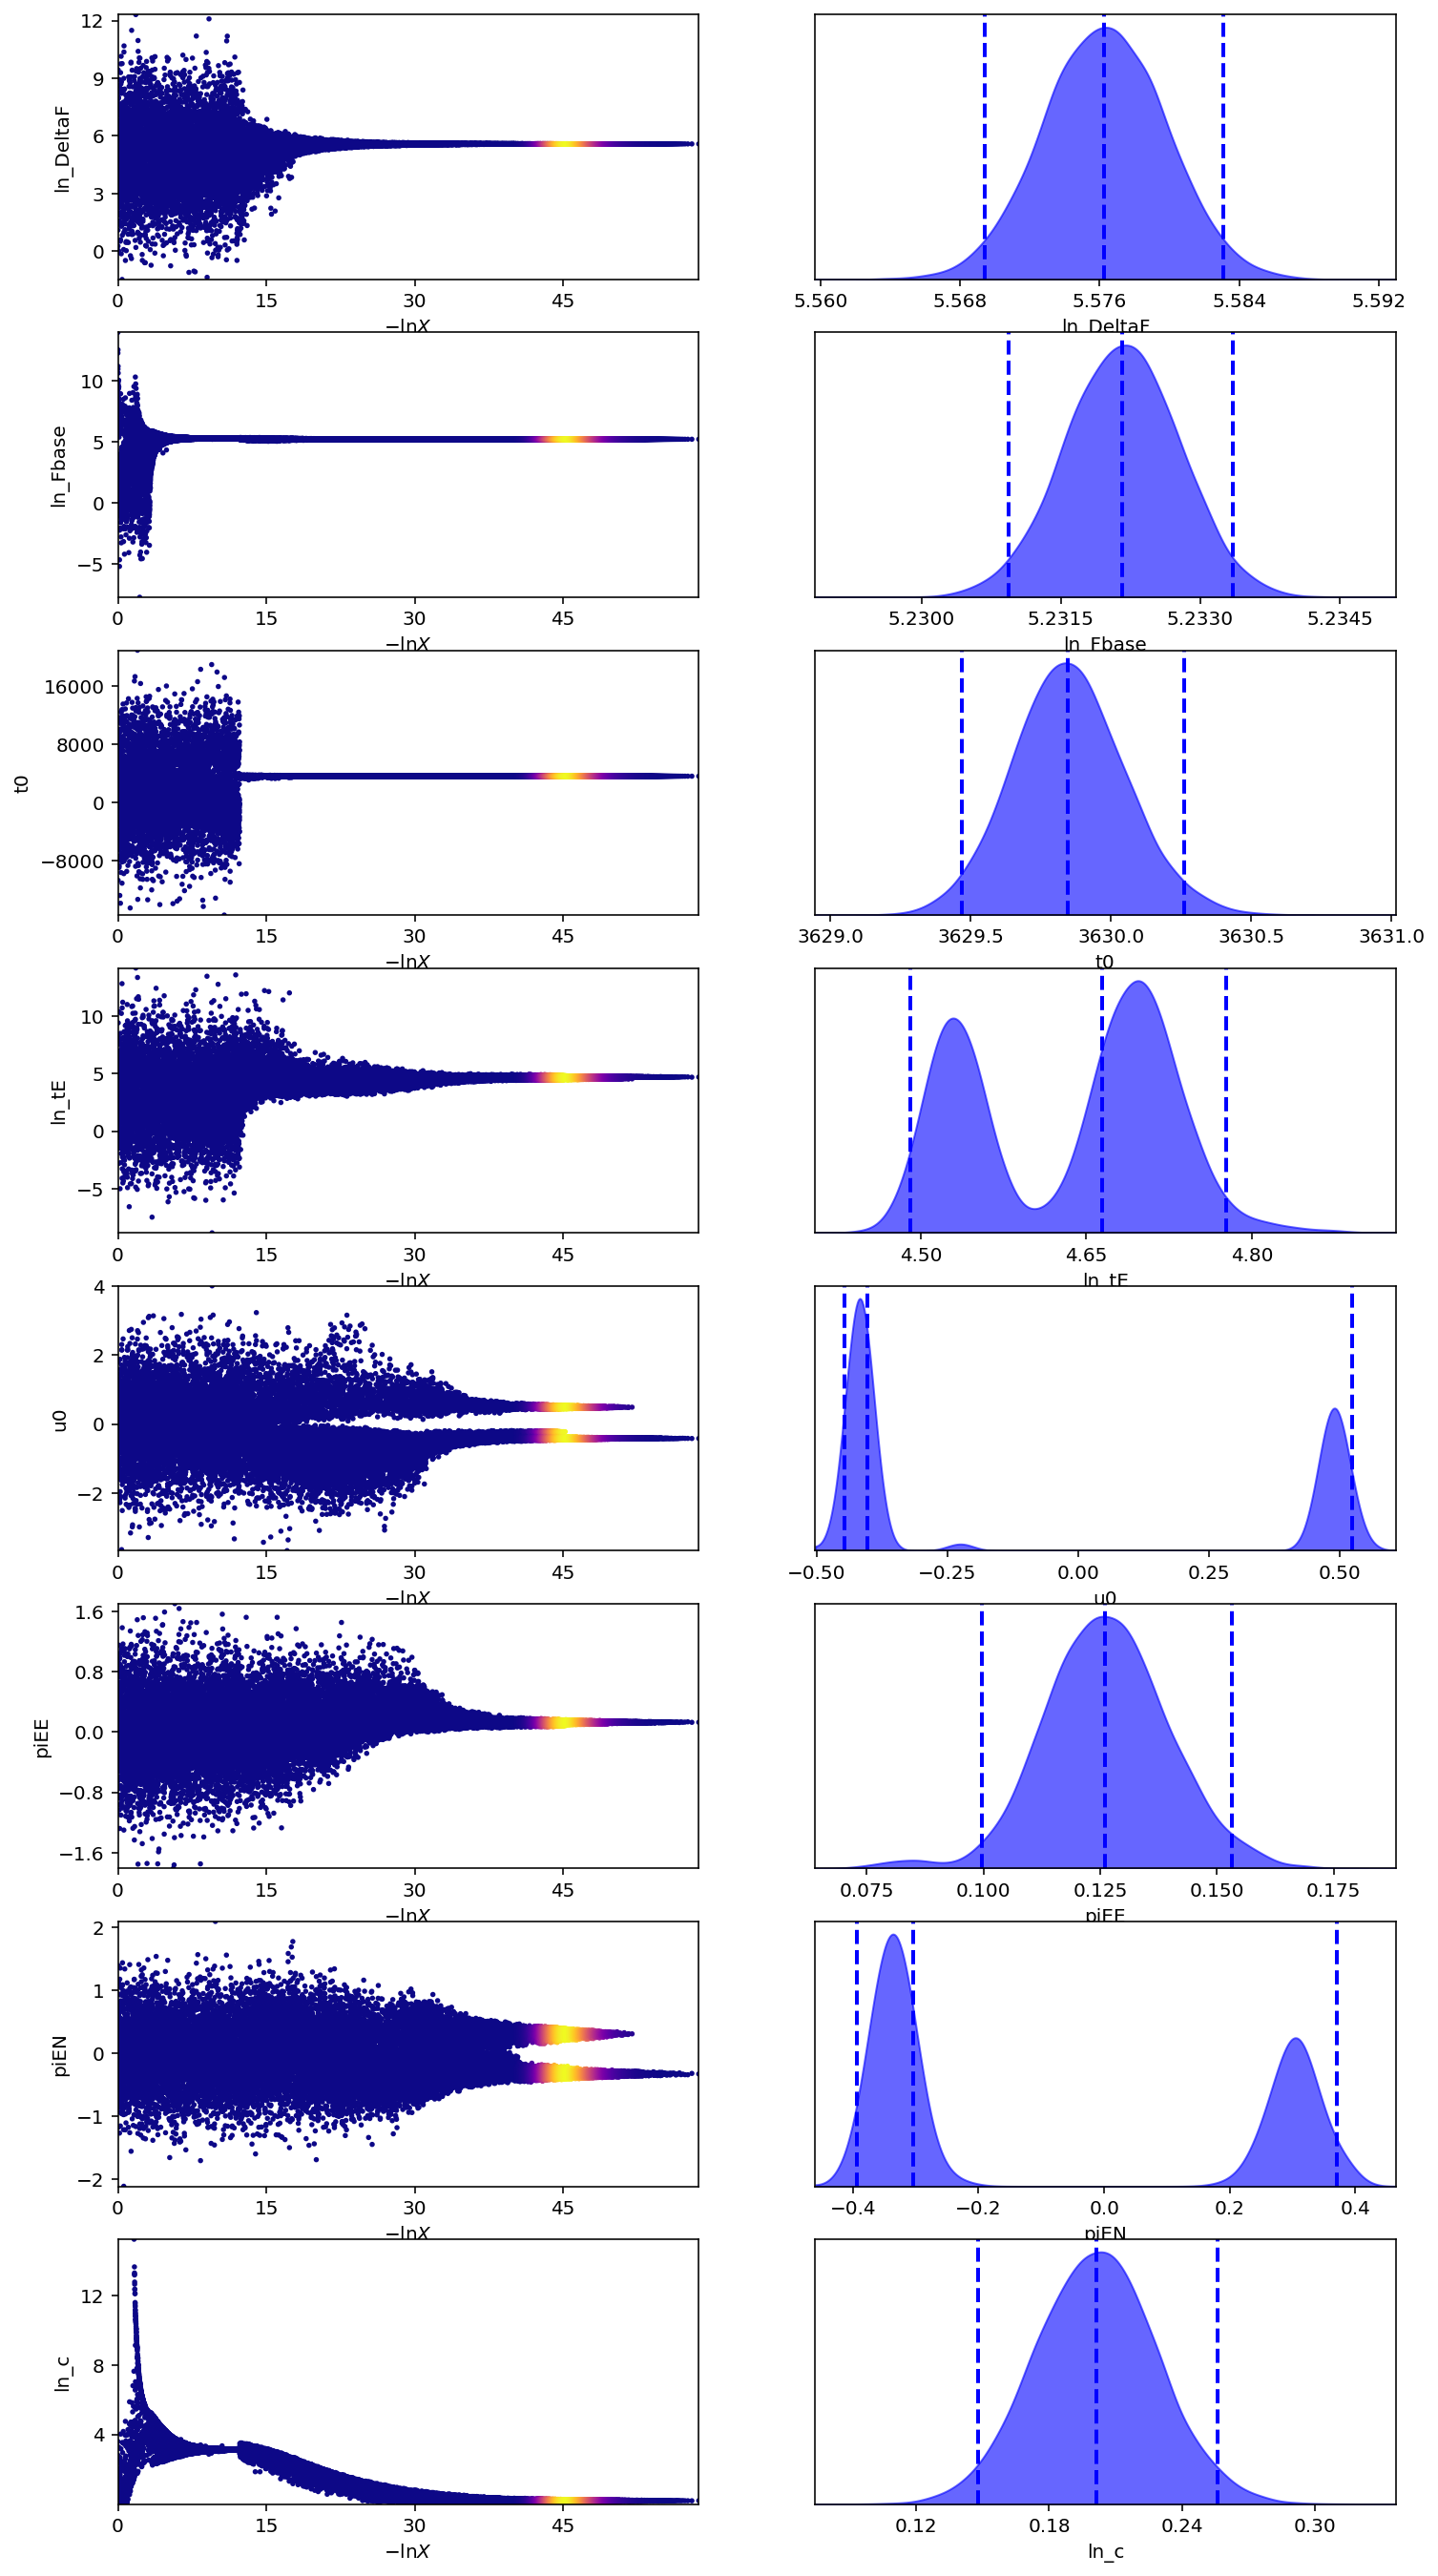

In [49]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
fig = plt.subplots(4, 1, figsize=(10, 8))
rfig, raxes = dyplot.runplot(results, fig=fig)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(
    results,
    labels=["ln_DeltaF", "ln_Fbase", "t0", "ln_tE", "u0", "piEE", "piEN", "ln_c"],
)

Let's plot the posterior over the $u_0$ parameter, which we expect to be multi-modal

Text(0.5, 0, '$u_0$')

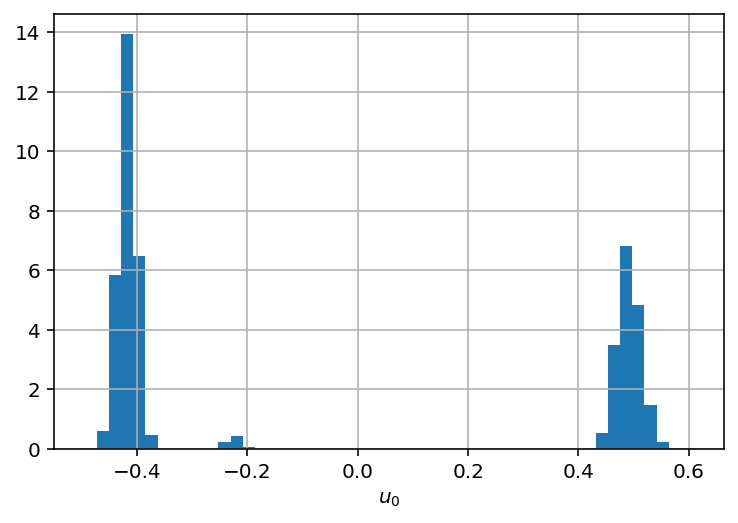

In [50]:
# Plot posterior for u0
fig, ax = plt.subplots()

ax.hist(samples_reweighted[:, 4], bins=50, density=True)
ax.grid()
ax.set_xlabel("$u_0$")

Looks like `dynesty` not only managed to discover both significant modes in the posterior, but also the relative height between the two modes matches what we've oberved in the [annual parallax example](annual_parallax.ipynb).

Let's plot the model to check that it makes sense, and plot the posterior trajectories from the multi-modal pdf.

In [115]:
with model:
    # Create dense grid
    t_dense = np.tile(np.linspace(model.t_min, model.t_max, 1000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense)

    # Evaluate trajectory components on dense grid
    u, un, ue = trajectory.compute_trajectory(t_dense_tensor, return_components=True)

    # Compute the magnification
    mag_dense = model.compute_magnification(T.sqrt(un ** 2 + ue ** 2), u0)

    # Compute the mean model
    mean_dense = DeltaF * mag_dense + Fbase

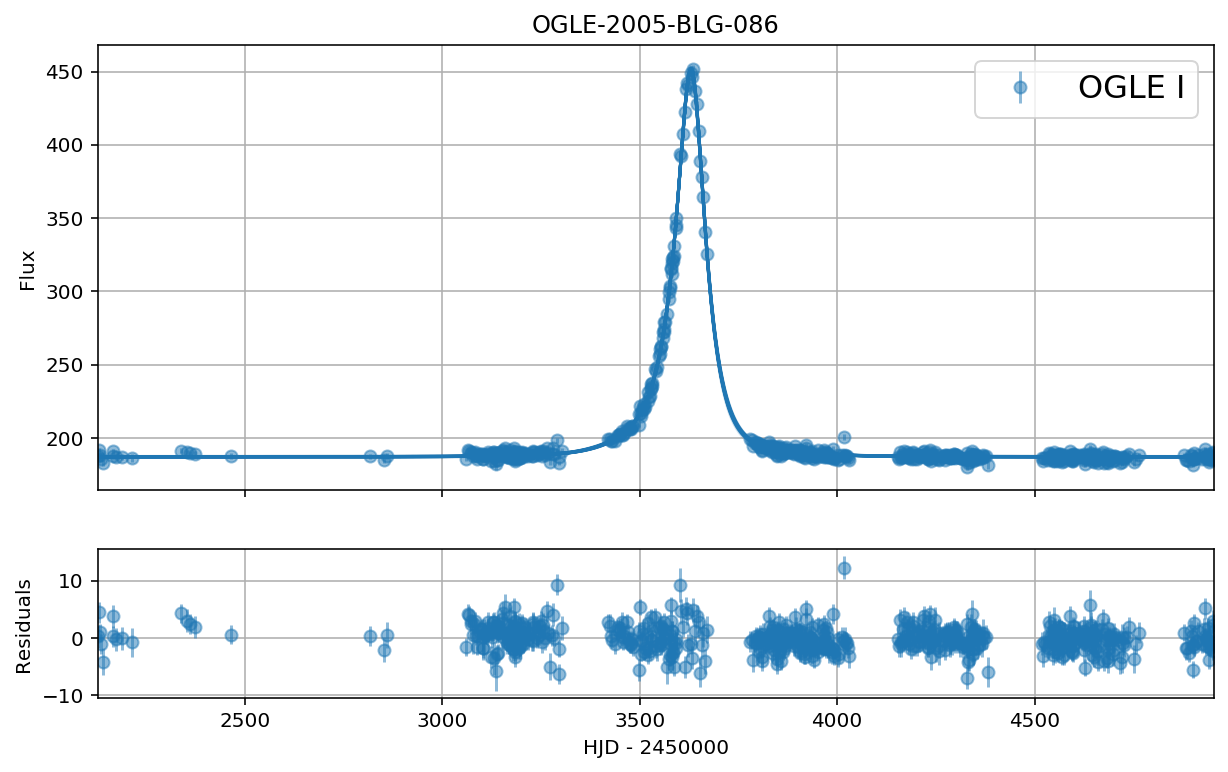

In [131]:
# To plot the model, we need to transform the transformed parameters
def get_samples_from_array(array, size=1):
    for i in range(size):
        sample_idx = np.random.randint(len(array))
        yield model.bijection.rmap(array[sample_idx][::-1])


# Plot model
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(10, 6), sharex=True
)

samples = list(get_samples_from_array(samples_reweighted, size=50))

with model:
    ca.utils.plot_model_and_residuals(ax, event, samples, t_dense_tensor, mean_dense)

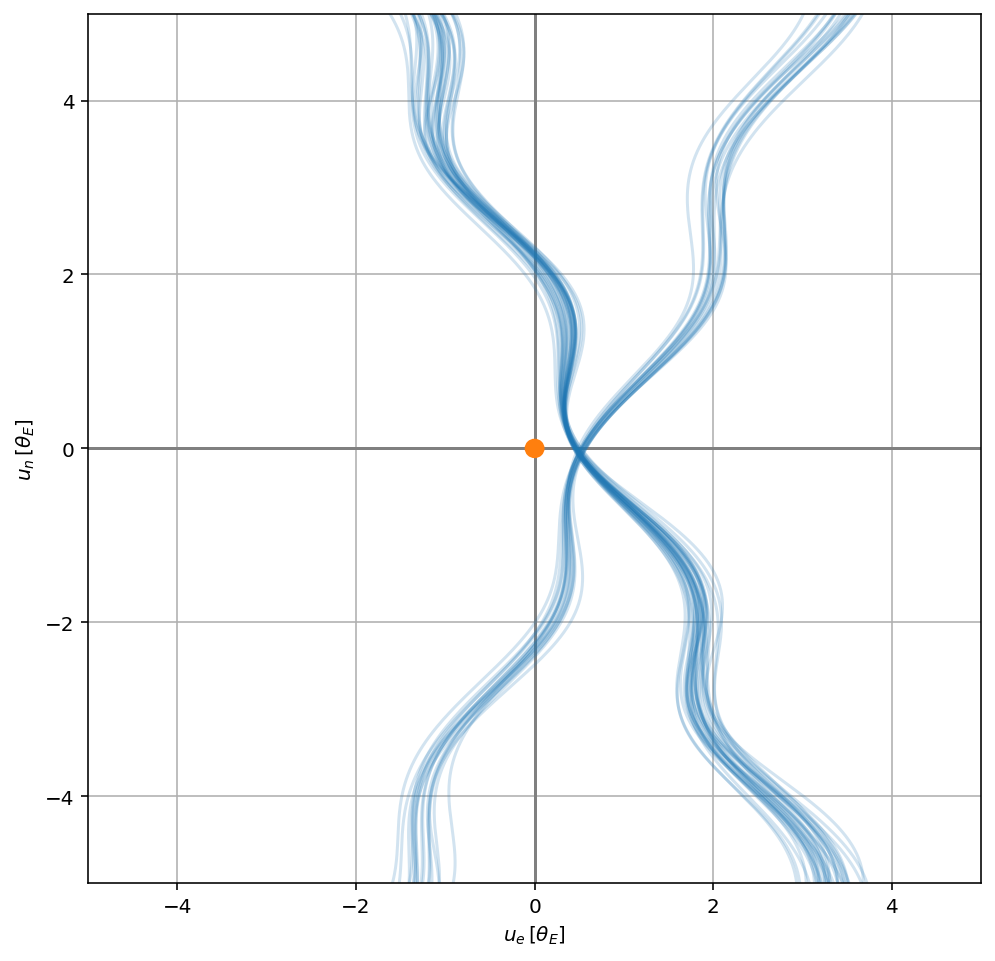

In [138]:
# Plot trajectory
fig, ax = plt.subplots(figsize=(8, 8))

with model:
    ca.utils.plot_trajectory_from_samples(
        ax, samples, t_dense_tensor, un, ue, color="C0"
    )

Looks good. Whereas in the parallax example with HMC we had to manually discover the different modes and had no idea about their relative importance, `dynesty` properly sampled the full pdf.